# Historical Data Platform QA/QC Event Evaluation Procedure

**Event**: Santa Ana Wind Event<br>
Start date: 2/16/1988<br> 
End date: 2/19/1988<br>
Location: Los Angeles, Orange counties<br>
Variables: wind speed, wind direction, air temperature, humidity<br>

In [1]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys

from qaqc_eval_utils import (id_all_flags, subset_eval_stns, latlon_to_mercator_cartopy, pull_nc_from_aws, return_ghcn_vars)
from qaqc_eval_plot import stn_visualize

sys.path.append(os.path.expanduser('../'))
from qaqc_plot import flagged_timeseries_plot
# from QAQC_pipeline import qaqc_ds_to_df # not working at present

### Step 1: Retrieve relevant station files and comparison data for evaluation
Read in training list of QA/QC'd stations.

In [2]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')
train_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72278303185,423.3672,33.466,-111.721,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
1,ASOSAWOS,ASOSAWOS_72278403184,453.2376,33.690,-112.066,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
2,ASOSAWOS,ASOSAWOS_72278903192,436.1688,33.612,-111.923,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
4,ASOSAWOS,ASOSAWOS_72281703068,1837.9440,38.767,-104.300,2006-05-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN


For event evaluation, randomly sample for a manageable number of stations per event using the `subset_eval_stns` function.

In [3]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = 4,
    return_stn_ids = True
)

9 potential stations available for evaluation for santa_ana_wind event.
4 stations selected for evaluation for santa_ana_wind event!
Stations selected for evaluation:
 ['CIMIS_75', 'ASOSAWOS_72292023191', 'ASOSAWOS_72382023182', 'ASOSAWOS_72383023187']


Visualize the station next

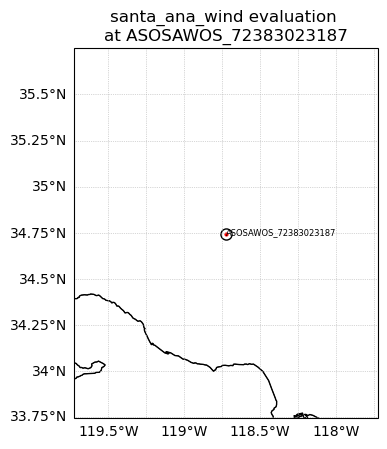

In [4]:
stn_visualize(
    stn_id = 'ASOSAWOS_72383023187',
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

# add county boundaries, fix labels

### Step 2: Holistic / qualitative station evaluation
* downloading these stations manually into train_files, but should grab from AWS unless a better way to read nc files from AWS...

In [ ]:
# phase 2 look at full timeseries for flags -- grabbing clean version, not qaqc version to build out
# alternatively.... some of these files may be very large and we should avoid reading in all because of memory concerns

# for stn in event_stns:
#     want to pull out all flags noted, frequency of flags of time record 

In [5]:
ds = pull_nc_from_aws('ASOSAWOS_72383023187')
ds

<xarray.Dataset>
Dimensions:               (station: 1, time: 572009)
Coordinates:
  * station               (station) object 'ASOSAWOS_72383023187'
  * time                  (time) datetime64[ns] 1980-01-01 ... 2022-08-31T23:...
Data variables: (12/34)
    ps                    (station, time) float64 ...
    tas                   (station, time) float64 ...
    tdps                  (station, time) float64 ...
    pr                    (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    ps_altimeter_eraqc    (station, time) float64 ...
    psl_eraqc             (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/19)
    title:                 ASOSAWOS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               ASOSAWOS_clean.py script run on 02-06-2023, 23:43:...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    GHCN-DailyID:          USW00023187
    Networks:              ASOS,COOP
    thermometer_height_m:  nan
    anemometer_height_m:   10.06
    barometer_elev_m:      -30479.7
    raw_files_merged:      43

In [6]:
id_all_flags(ds)

ps_eraqc [11. 25. 28. nan]
tas_eraqc [23. 26. 27. 28. nan]
tdps_eraqc [13. 23. 26. 27. 28. nan]
pr_eraqc [nan]
sfcWind_eraqc [27. nan]
sfcWind_dir_eraqc [14. nan]
elevation_eraqc [nan]
ps_altimeter_eraqc [23. 27. 28. nan]
psl_eraqc [21. 23. 28. nan]


In [7]:
%%time 
df_test = ds.to_dataframe().reset_index() # takes about 4 min...

/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


CPU times: user 38.8 s, sys: 7.69 s, total: 46.5 s
Wall time: 3min 42s


In [8]:
df_test

,station,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,...,tas_eraqc,tdps_eraqc,pr_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,elevation_eraqc,ps_altimeter_eraqc,psl_eraqc,anemometer_height_m,thermometer_height_m
0,ASOSAWOS_72383023187,1980-01-01 00:00:00,NaN,283.15,278.15,0.0,4.6,340.0,1377.0,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
1,ASOSAWOS_72383023187,1980-01-01 01:00:00,NaN,280.95,277.55,0.0,4.1,340.0,1377.0,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
2,ASOSAWOS_72383023187,1980-01-01 02:00:00,NaN,280.35,277.05,0.0,2.0,360.0,1377.0,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
3,ASOSAWOS_72383023187,1980-01-01 03:00:00,NaN,280.35,277.55,0.0,4.6,320.0,1377.0,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
4,ASOSAWOS_72383023187,1980-01-01 04:00:00,NaN,280.35,277.55,0.0,3.0,320.0,1377.0,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572004,ASOSAWOS_72383023187,2022-08-31 19:53:00,86550.0,308.75,274.85,0.0,5.7,170.0,1379.0,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
572005,ASOSAWOS_72383023187,2022-08-31 20:53:00,86550.0,308.75,275.35,0.0,3.6,270.0,1379.0,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
572006,ASOSAWOS_72383023187,2022-08-31 21:53:00,86490.0,308.15,274.85,0.0,2.6,NaN,1379.0,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN
572007,ASOSAWOS_72383023187,2022-08-31 22:53:00,86460.0,307.55,273.75,0.0,8.2,320.0,1379.0,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN


In [ ]:
# need to convert to a df to use fn -- is it more efficient to id flags from ds or df? 
## this is slow! taking approx... 
df = qaqc_ds_to_df(ds)
df
# flagged_timeseries_plot(df, var='tas')

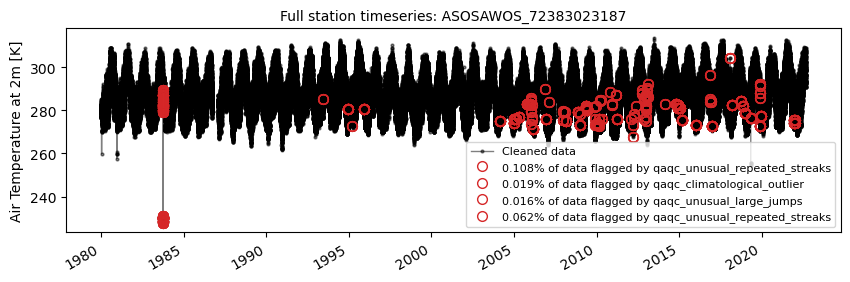

In [9]:
flagged_timeseries_plot(df_test, var='tas')

In [ ]:
# look at full timeseries for holistic view
ds.tas_eraqc.plot()

In [ ]:
# look at timeseries of all months of that event (e.g., all februaries) to understand climatological signal?
month = [2]
stn_monthly_clim = stn.isel(time=stn.time.dt.month.isin(month))

stn_monthly_clim.sfcWind.plot(marker=".", lw=0)

# hmm not so useful, perhaps a climatology of the month to compare with the event

In [ ]:
# look at timeseries during event for flags
# decision: do we add a few days prior/after event end date to evaluate "event anomaly"? i think this may be useful
# santa ana event was 2/16/1988 to 2/19/1988; including +/- 1 week
event_start_date = '1988-02-09'
event_end_date = '1988-02-26'

# subset for event period of time
event = stn.sel(time=slice(event_start_date, event_end_date))

In [ ]:
# just grabbing a single var for the event itself
event.sfcWind.plot()

In [ ]:
event.sfcWind_dir.plot()

#### Append local GHCNh library path

In [ ]:
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
# from GHCNh.GHCNh_lib import GHCNh  # If GHCNh is within current folder
from GHCNh_lib import GHCNh # If GHCNh is was appended to path

In [ ]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
ghcnh.station_data.head(3)

In [ ]:
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

In [ ]:
fig,ax = plt.subplots(figsize=(9,3))

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat));

In [ ]:
# initial test for identifying the event: large jumps on windspeed

In [ ]:
return_ghcn_vars(ghcnh.station_data, 'sfcWind').head(3)